# Plotting color-color diagram for HST/SDSS sources

In this notebook we show the color-color diagram ($g-r$ v.s. $z-y$) for sources from the HSTxPS1 and the SDSSxPS1 . 

Since the color of a star and a galaxy should depend on the redshift and the type of it, 
the distribution on the color-color diagram is different between the HST dataset and the SDSS dataset. 
To avoid the systematic effect on the star/galaxy classification, we decided to exclude the color information from the training dataset.

In [1]:
import sys,os,math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
from matplotlib import gridspec as grs
%matplotlib inline
from matplotlib import cm
from astropy.table import Table
import seaborn as sns
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.special import expit
from scipy import stats

In [ ]:
def kde_contour_dat(x, y, extent = 'Auto', bw_type = "silverman", grid_bins = 250, BW=False):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == 'Auto':
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])
    if BW:
        bw = BW

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

In [2]:
cat = pd.read_csv("HST_PS1_stack_mean_Object_Thin_tachibana.csv")

In [3]:
det = (cat.gKronFlux > 0) & (cat.rKronFlux > 0) & (cat.zKronFlux > 0) & (cat.yKronFlux > 0)
star = cat.MU_CLASS[det] == 2
galaxy = cat.MU_CLASS[det] == 1

In [4]:
color_gr = -2.5*np.log10(cat.gKronFlux[det]/cat.rKronFlux[det])
color_zy = -2.5*np.log10(cat.zKronFlux[det]/cat.yKronFlux[det])

In [60]:
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

xgal_col, ygal_col, zgal_col = kde_contour_dat(color_gr[galaxy], color_zy[galaxy], 
                                                     grid_bins=200, extent=(-0.25, 2.3, -0.75, 0.95))
xstar_col, ystar_col, zstar_col = kde_contour_dat(color_gr[star], color_zy[star], 
                                                        grid_bins=200,  extent=(-0.25, 2.3, -0.75, 0.95))

In [15]:
sdss = pd.read_csv("SDSS_DR14_PS1_Stack_flux_All.csv")

In [16]:
det_sdss = (sdss.gKronFlux > 0) & (sdss.rKronFlux > 0) & (sdss.zKronFlux > 0) & (sdss.yKronFlux > 0)
star_sdss = sdss['class'][det_sdss] == 'STAR'
galaxy_sdss = sdss['class'][det_sdss] != 'STAR'

In [17]:
color_gr_sdss = -2.5*np.log10(sdss.gKronFlux[det_sdss]/sdss.rKronFlux[det_sdss])
color_zy_sdss = -2.5*np.log10(sdss.zKronFlux[det_sdss]/sdss.yKronFlux[det_sdss])

In [62]:
xgal_col_sdss, ygal_col_sdss, zgal_col_sdss = kde_contour_dat(color_gr_sdss[galaxy_sdss], color_zy_sdss[galaxy_sdss], 
                                                     grid_bins=200, extent=(-0.25, 2.3, -0.75, 0.95))
xstar_col_sdss, ystar_col_sdss, zstar_col_sdss = kde_contour_dat(color_gr_sdss[star_sdss], color_zy_sdss[star_sdss], 
                                                        grid_bins=200, extent=(-0.25, 2.3, -0.75, 0.95))

In [71]:
pd.DataFrame(zgal_col_sdss).to_csv('KDE_ColorColor_galaxy_SDSS.csv', header=None, index=None)
pd.DataFrame(zstar_col_sdss).to_csv('KDE_ColorColor_star_SDSS.csv', header=None, index=None)

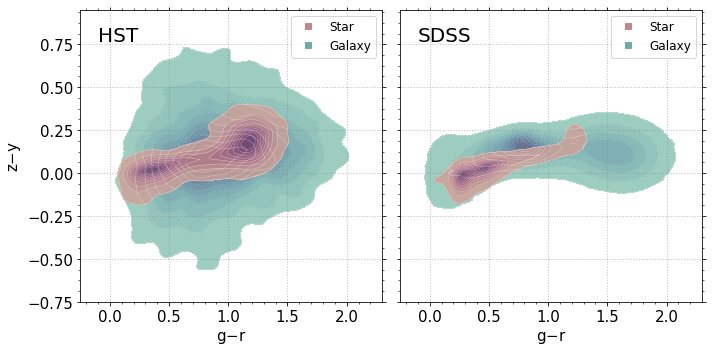

In [67]:
xlims = [-0.25, 2.3]
ylims = [-0.75, 0.95]
origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)

plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True, labelsize = 15)
plt.minorticks_on()

plt.plot(-10, -10, 's', 
        label='Star', color = cmap_star(0.25))
plt.plot(-10, -10, 's', 
        label='Galaxy', color = cmap_gal(0.25))

plt.text(-0.1, 0.80, 'HST', ha = 'left', va = 'center', fontsize=20)

plt.contourf(xgal_col, ygal_col, zgal_col, levels = levels,
             origin = origin,
             cmap = cmap_gal, alpha = 0.8)
plt.contour(xgal_col, ygal_col, zgal_col, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
plt.contourf(xstar_col, ystar_col, zstar_col, levels = levels,  
               origin = origin,
               cmap = cmap_star, alpha = 0.8)
plt.contour(xstar_col, ystar_col, zstar_col, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)  
plt.yticks(np.arange(-10, 10, 0.25))
plt.xlim(xlims); plt.ylim(ylims)
plt.xlabel('g$-$r', fontsize=15); plt.ylabel('z$-$y', fontsize=15)
plt.legend(loc='best', fontsize=12)


plt.subplot(1,2,2)
plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True, labelsize = 15, labelleft='off')
plt.minorticks_on()

plt.plot(-10, -10, 's', 
        label='Star', color = cmap_star(0.25))
plt.plot(-10, -10, 's', 
        label='Galaxy', color = cmap_gal(0.25))

plt.text(-0.1, 0.80, 'SDSS', ha = 'left', va = 'center', fontsize=20)

plt.contourf(xgal_col_sdss, ygal_col_sdss, zgal_col_sdss, levels = levels,
             origin = origin,
             cmap = cmap_gal, alpha = 0.8)
plt.contour(xgal_col_sdss, ygal_col_sdss, zgal_col_sdss, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
plt.contourf(xstar_col_sdss, ystar_col_sdss, zstar_col_sdss, levels = levels,  
               origin = origin,
               cmap = cmap_star, alpha = 0.8)
plt.contour(xstar_col_sdss, ystar_col_sdss, zstar_col_sdss, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)  

plt.yticks(np.arange(-10, 10, 0.25))
plt.xlim(xlims); plt.ylim(ylims)
plt.xlabel('g$-$r', fontsize=15); #plt.ylabel('z$-$y', fontsize=15)
plt.legend(loc='best', fontsize=12)

plt.tight_layout()

plt.savefig('ColorColorDiagram.pdf')